In [1]:

from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%env CUDA_LAUNCH_BLOCKING=1
#cudnn.benchmark = True
#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


env: CUDA_LAUNCH_BLOCKING=1
Random Seed:  781


In [2]:
#loading the dataset
dataset = dset.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
#number of channels in image(since the image is grayscale the number of channels are 1)
nc=1

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

In [4]:
class GeneratorLinear(nn.Module):
    def __init__(self, nz=100, nh1=256, nh2=512, noutput=784):
        super(GeneratorLinear, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(nz,nh1),
            nn.ReLU(),
            nn.Linear(nh1,nh2),
            nn.ReLU(),
            nn.Linear(nh2,noutput),
            nn.Tanh()
        )
    def forward(self, input):
        output = self.main(input)
        return output

netG = GeneratorLinear().to(device)
print(netG)

GeneratorLinear(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [5]:
class DiscriminatorLinear(nn.Module):
  def __init__(self, nimputs=784, nh1=512, nh2=256):
        super(DiscriminatorLinear, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28x28
            nn.Linear(nimputs,nh1),
            nn.ReLU(True),
            nn.Linear(nh1,nh2),
            nn.ReLU(True),
            nn.Linear(nh2,1),
            nn.ReLU(True),

        )

  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)

netD = DiscriminatorLinear().to(device)
print(netD)

DiscriminatorLinear(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): ReLU(inplace=True)
  )
)


In [6]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters()) #, lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters()) #, lr=0.0002, betas=(0.5, 0.999))


In [7]:
fixed_noise = torch.randn(64, nz, device=device)
real_label = 1
fake_label = 0

niter = 25


[0/25][0/938] Loss_D: 93.9957 Loss_G: 100.0000 D(x): 0.0000 D(G(z)): 0.0000


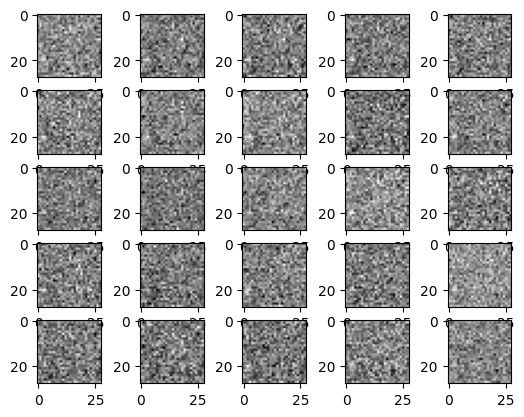

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:

# Commented out IPython magic to ensure Python compatibility.
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        optimizerD.zero_grad()
        # computer err with real
        x = data[0].view([-1,784]).to(device)
        o = netD(x)
        batch_size = x.size(0)
        desired = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        err_real = criterion(o,desired)
        D_x = o.mean()
        # compute err with fake
        z = torch.randn(batch_size, nz, device=device)
        fake = netG(z)
        o = netD(fake.detach())
        desired = torch.full((batch_size,), fake_label, device=device, dtype=torch.float)
        err_fake = criterion(o, desired)
        D_x = o.mean().item()
        # train D
        err_total = err_real + err_fake
        err_total.backward()
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.zero_grad()
        netG.zero_grad()    
        
        z = torch.rand(batch_size, nz, device=device)
        fake = netG(z)
        o = netD(fake)
        desired = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        err_fake = criterion(o, desired)
        err_fake.backward()
        D_z = o.mean().item()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
                   % (epoch, niter, i, len(dataloader),
                     err_total.item(), err_fake.item(), D_x, D_z))
        if i % 100 == 0:
            fake = netG(fixed_noise)
            fake_images_np = fake.cpu().detach().numpy()
            fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
            R, C = 5, 5
            num_images_to_plot = min(batch_size, R * C)  # Limit images to plot to grid size
            for i in range(num_images_to_plot):
                plt.subplot(R, C, i + 1)
                plt.imshow(fake_images_np[i], cmap='gray')
            plt.show()
